# Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gc
import os
import warnings
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import ngrams
from collections import Counter
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
from keras.preprocessing.text import Tokenizer

pyLDAvis.enable_notebook()
np.random.seed(2018)
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yashima/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


In [2]:
import IPython.display
pd.options.display.max_columns = None

# Load Data

In [3]:
sample = pd.read_csv('../data/sample_submission.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# EDA

## View Data

In [4]:
display(sample.head(3))
display(train.head(2))
display(test.head(2))

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448
2,70,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.0,0.333333,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.0,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.0,1.000000,0.0,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.0,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.0,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.0,0.666667,0.888889


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com


In [5]:
target_columns = train.columns[11:]

In [6]:
print("Train and test shape: {} {}".format(train.shape, test.shape))

Train and test shape: (6079, 41) (476, 11)


## question_title

**Distribution of character length in question_title (i.e. number of characters)**

In [7]:
train['question_title'].str.len()

0        68
1       108
2        56
3        37
4        44
       ... 
6074     36
6075     54
6076     50
6077     40
6078     76
Name: question_title, Length: 6079, dtype: int64

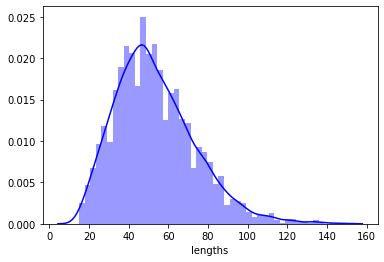

In [8]:
lengths = train['question_title'].apply(len)
train['lengths'] = lengths
lengths = train.loc[train['lengths']<4000]['lengths']
sns.distplot(lengths, color='b')
plt.show()

- Although the lengths <u>seem to be skewed just a bit to the lower lengths</u>.\
We see another clear peak around the 45-50 character mark.

## question_body & answer

### Characters

**Distribution of characters in question_body & answer**

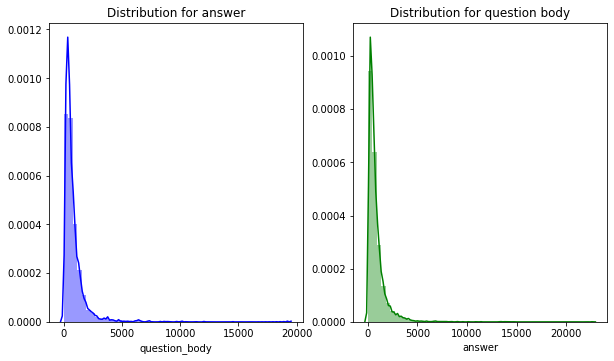

In [9]:
question_body=train['question_body'].str.len()
answer_body=train['answer'].str.len()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5.5))
sns.distplot(question_body,ax=ax1,color='blue')
sns.distplot(answer_body,ax=ax2,color='green')
ax2.set_title('Distribution for question body')
ax1.set_title('Distribution for answer')
plt.show()

- Both the distributions are left skewed and almost identical.

### Words

**Distribution of the number of words in the question_body**

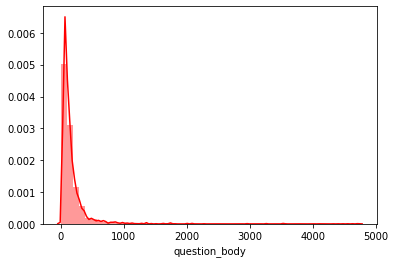

In [10]:
words = train['question_body'].apply(lambda x: len(x) - len(''.join(x.split())) + 1)
train['words'] = words
#words = train.loc[train['words']<500]['words']
sns.distplot(words, color='r')
plt.show()

It looks like we have a unimodal right-skewed distribution of the number of words in the question_body.

**Distribution of the number of words in the Answer**

Text(0.5, 1.0, 'Distribution of no: of words in answer')

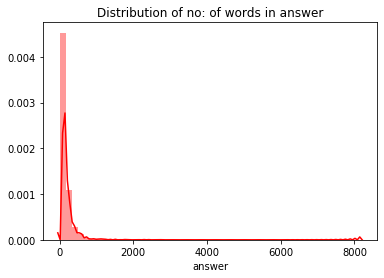

In [11]:
answer=train['answer'].apply(lambda x : len(x.split(' ')))
sns.distplot(answer,color='red')
plt.gca().set_title('Distribution of no: of words in answer')

**Average Word Length**

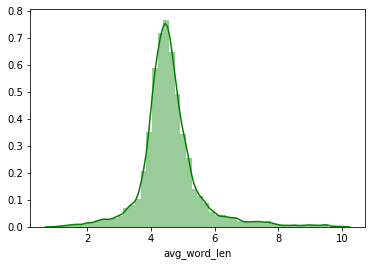

In [12]:
avg_word_len = train['answer'].apply(lambda x: 1.0*len(''.join(x.split()))/(len(x) - len(''.join(x.split())) + 1))
train['avg_word_len'] = avg_word_len
avg_word_len = train.loc[train['avg_word_len']<10]['avg_word_len']
sns.distplot(avg_word_len, color='g')
plt.show()

We have a simple bell-shaped normal distribution of the average word length with a mean of around 4.5

### Stop Words

In [13]:
stopwords=stopwords.words('english')
train['que_stopwords']=train['question_body'].apply(lambda x : [x for x in x.split() if x in stopwords])
train['ans_stopwords']=train['answer'].apply(lambda x: [x for x in x.split() if x in stopwords])

**Distribution of stopwords in question_body & answer**

Text(0.5, 1.0, 'Distribution of stopwords in  Answer')

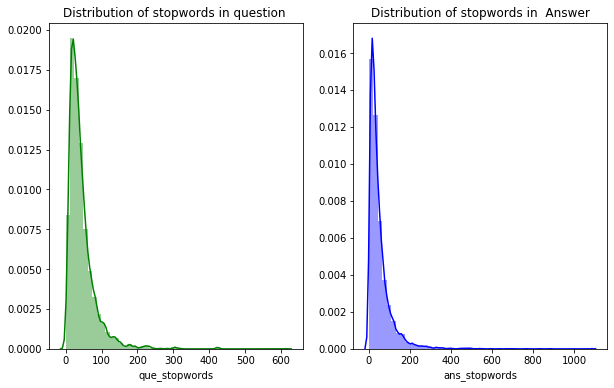

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
words=train['que_stopwords'].apply(lambda x : len(x))
sns.distplot(words,color='green',ax=ax1)
ax1.set_title('Distribution of stopwords in question ')
words=train['ans_stopwords'].apply(lambda x: len(x))
sns.distplot(words,color='blue',ax=ax2)
ax2.set_title('Distribution of stopwords in  Answer')

## Ngram analysis

In [15]:
def common_ngrams(col,common=10):
    corpus=[]
    for question in train[col].values:
        words=[str(x[0]+' '+x[1]) for x in ngrams(question.split(),2)]
        corpus.append(words)
    flatten=[x for one in corpus for x in one]
    counter=Counter(flatten)
    most_common=counter.most_common(common)
    string,value=zip(*(most_common))
    return string,value

### question_title

**Common bigrams in question title**

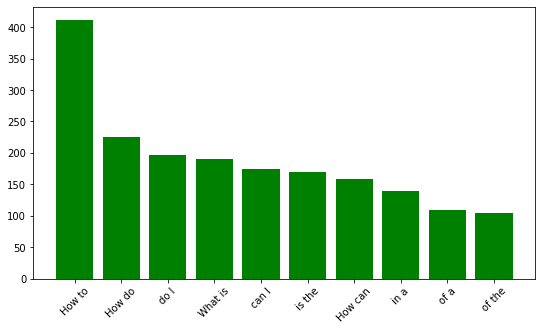

In [16]:
string,value=common_ngrams('question_title')
plt.figure(figsize=(9,5))
plt.bar(height=value,x=string,color='green')
plt.gca().set_xticklabels(string,rotation='45')
plt.show()

Well, as expected majority of questions start or have 'how to' or 'what is' with them.

### answer

**common biagrams in answer**

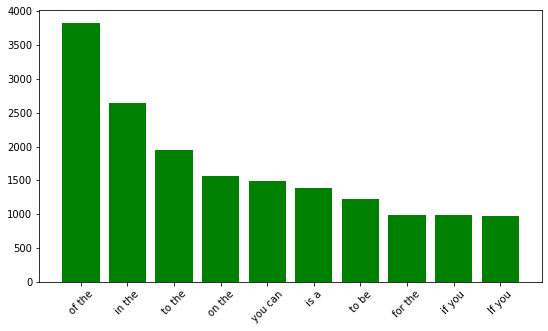

In [17]:
string,value=common_ngrams('answer')
plt.figure(figsize=(9,5))
plt.bar(height=value,x=string,color='green')
plt.gca().set_xticklabels(string,rotation='45')
plt.show()

## Feature Distribution

### question_not_really_a_question

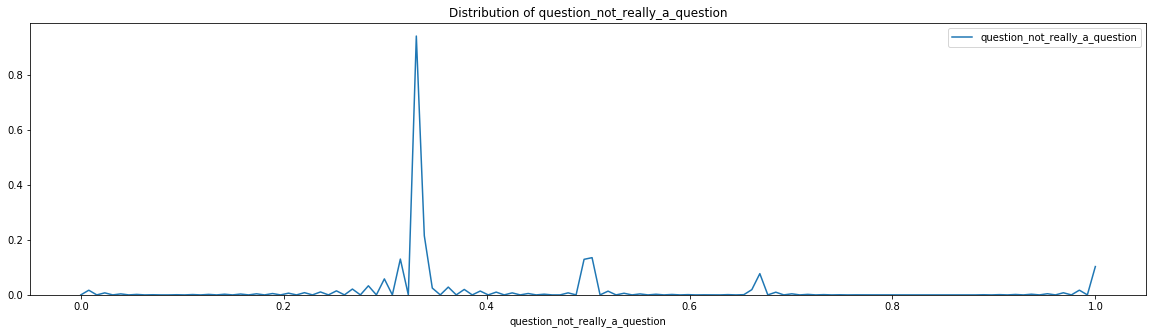

In [22]:
plt.figure(figsize=(20,5))
plt.title("Distribution of question_not_really_a_question")
sns.distplot(train['question_not_really_a_question'],kde=True,hist=False, bins=120, label='question_not_really_a_question')
plt.legend(); plt.show()

In cell above you can replace question_not_really_a_question with other keywords from targets variable to get exact distribution of that column

### targets

In [27]:
def plot_features_distribution(features, title):
    plt.figure(figsize=(15,10))
    plt.title(title)
    for feature in features:
        sns.distplot(train.loc[~train[feature].isnull(),feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

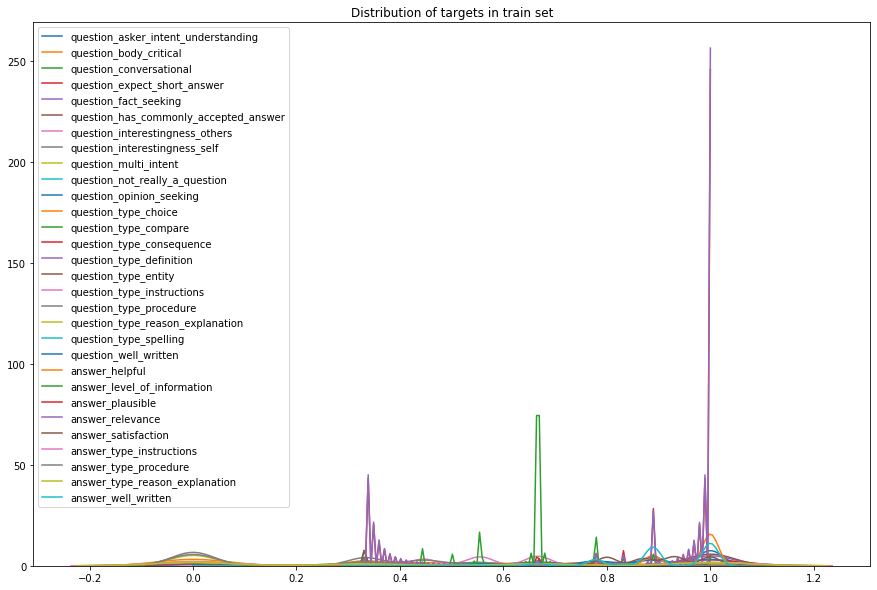

In [28]:
plot_features_distribution(target_columns, "Distribution of targets in train set")

### question_well_written & answer_well_written

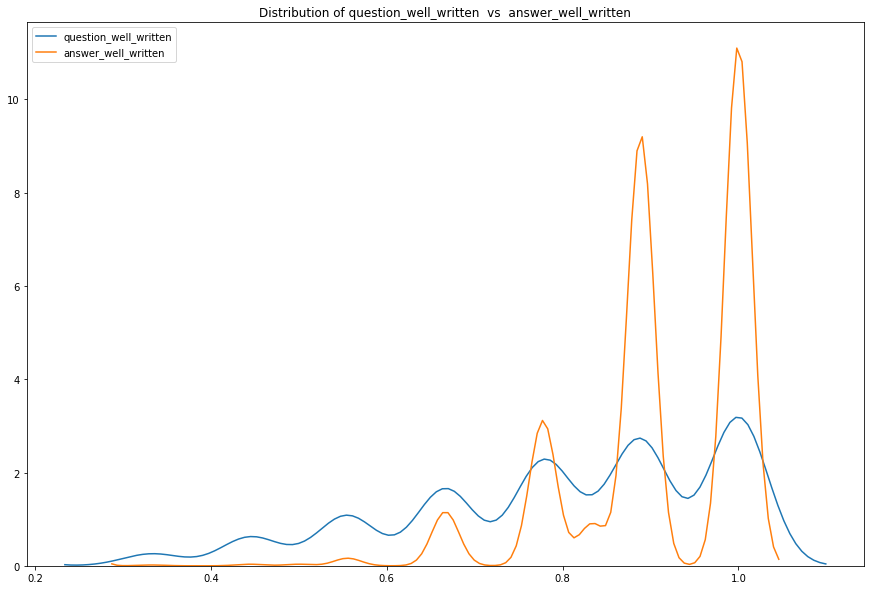

In [29]:
features = ['question_well_written','answer_well_written']
plot_features_distribution(features, "Distribution of question_well_written  vs  answer_well_written")

### Count Distribution

In [44]:
def plot_count(feature, title,size=1):
    f, ax = plt.subplots(1,1, figsize=(10,5))
    total = float(len(train))
    g = sns.countplot(train[feature].round(2), order = train[feature].round(2).value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2,
                height + 5,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

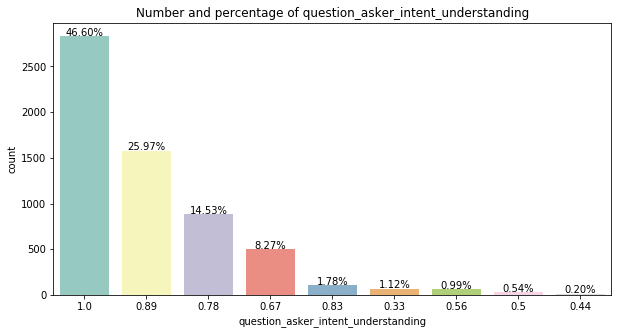

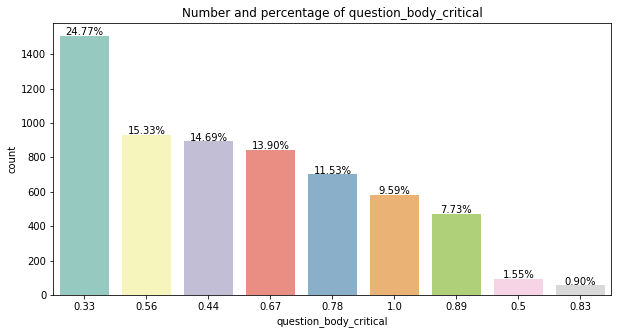

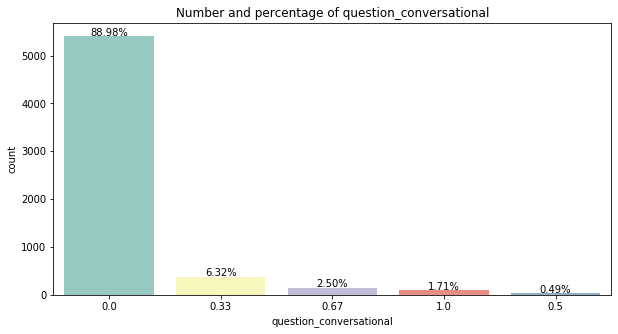

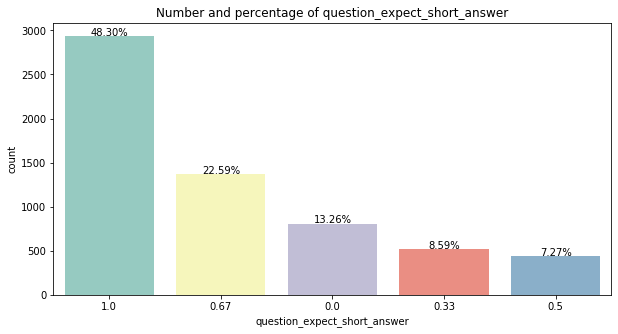

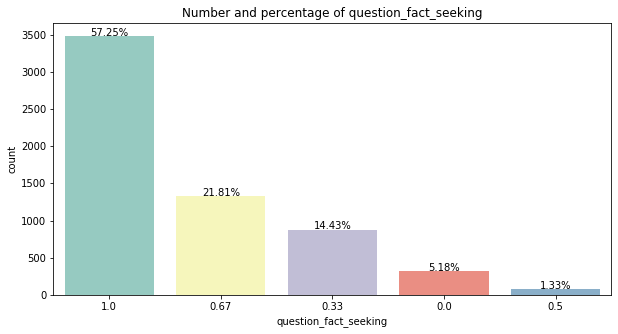

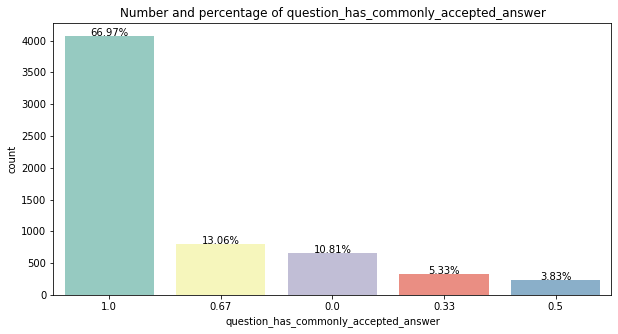

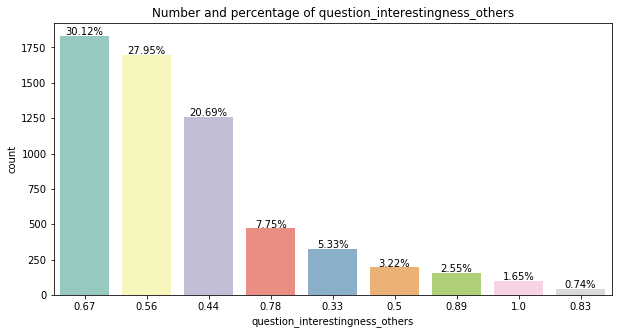

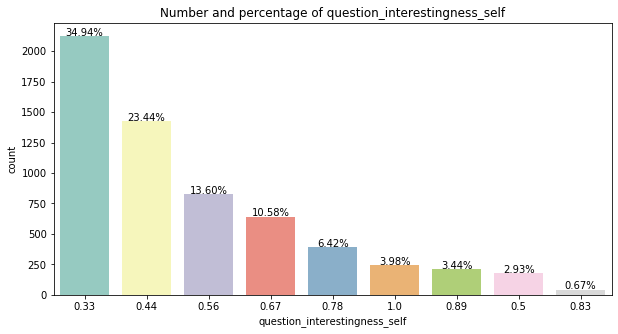

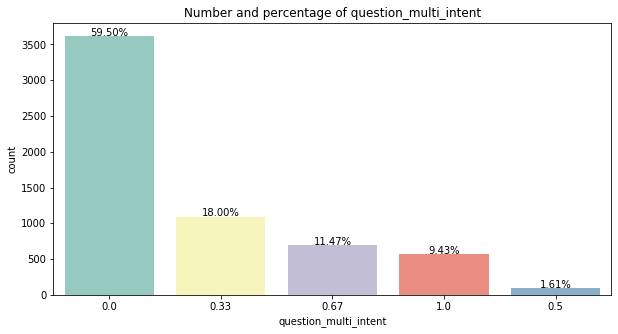

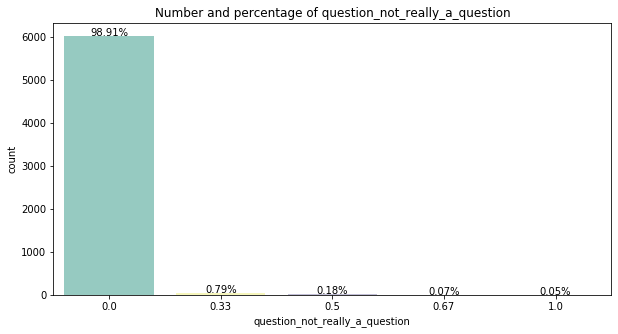

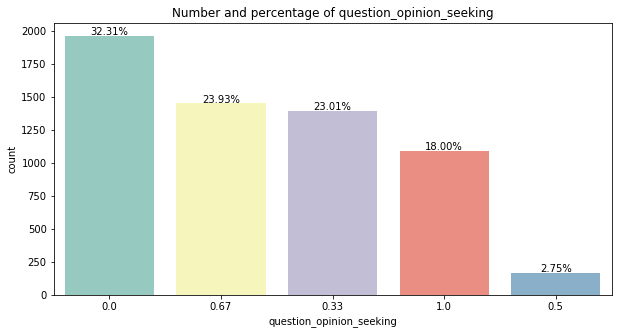

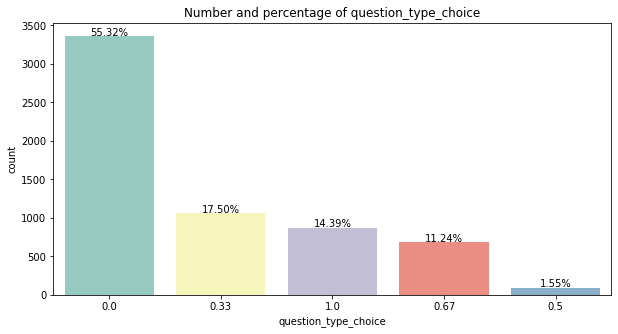

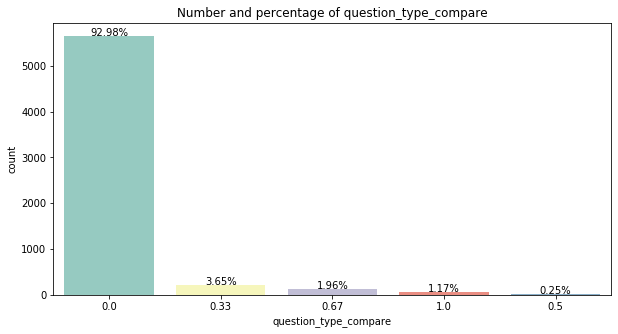

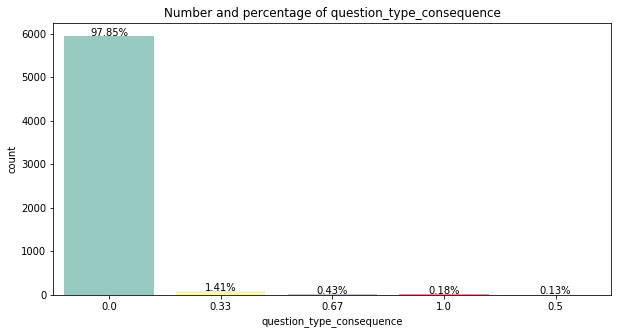

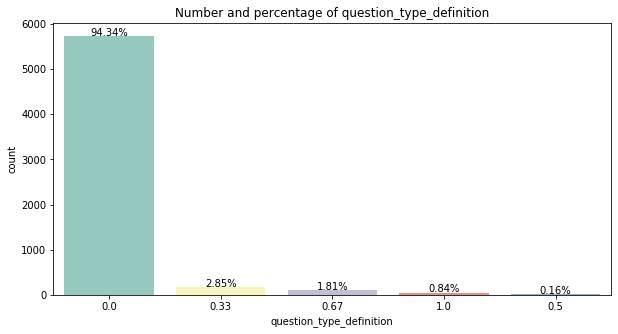

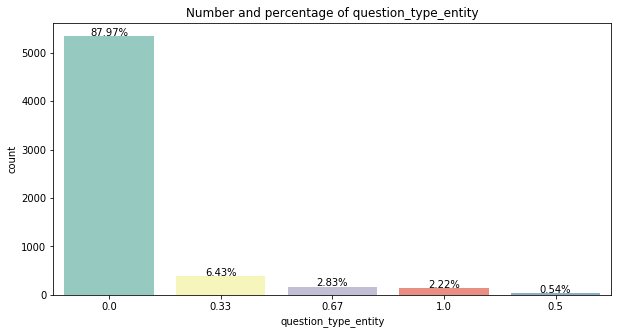

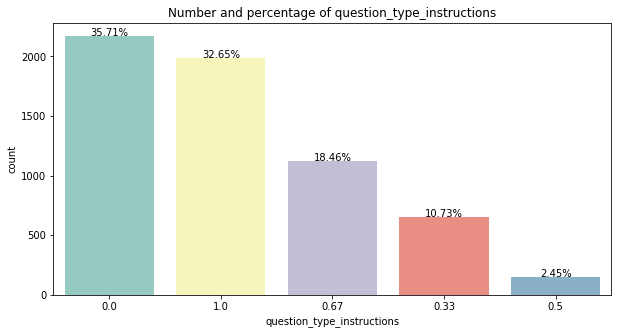

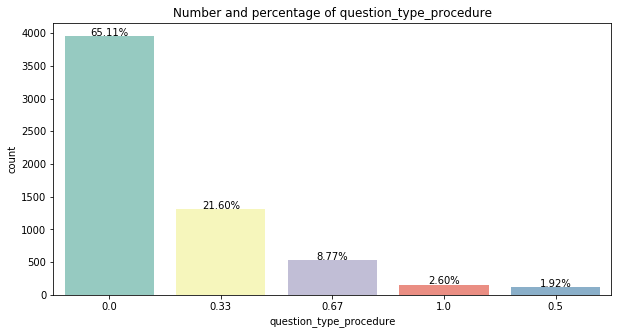

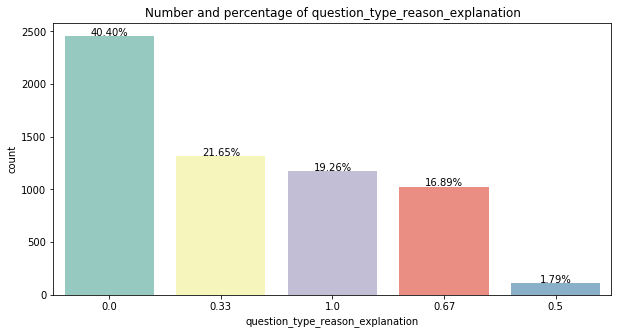

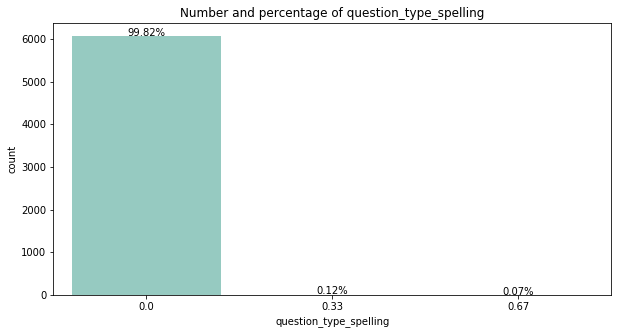

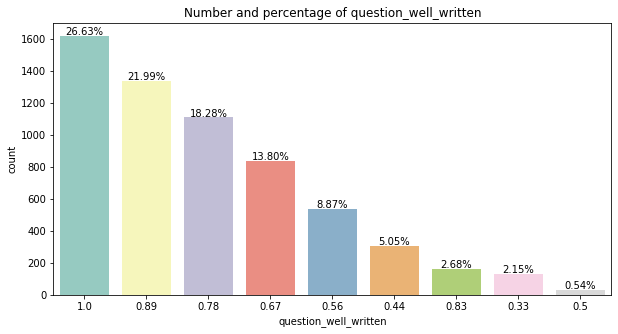

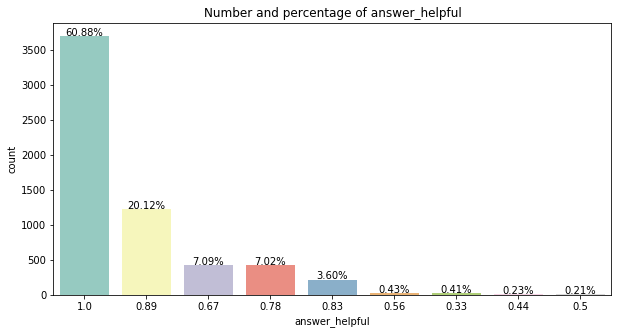

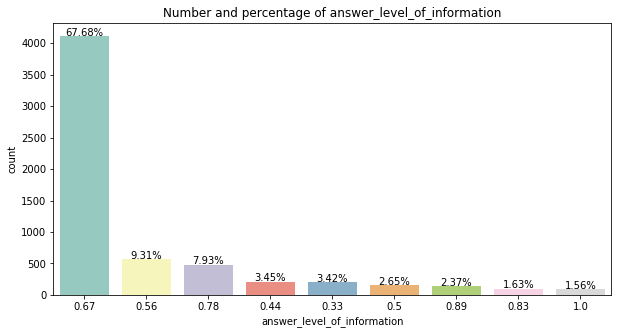

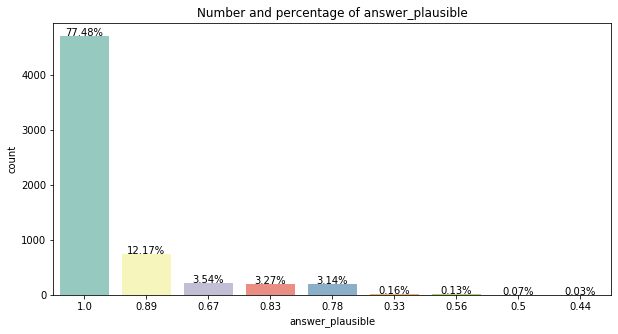

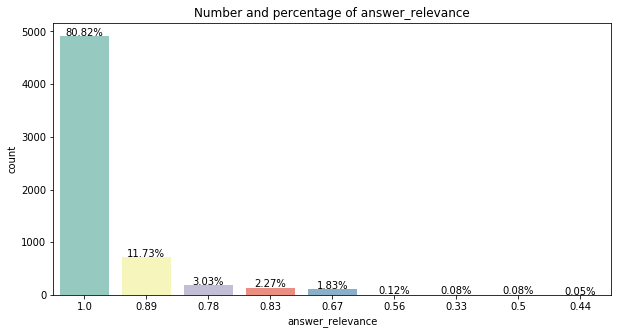

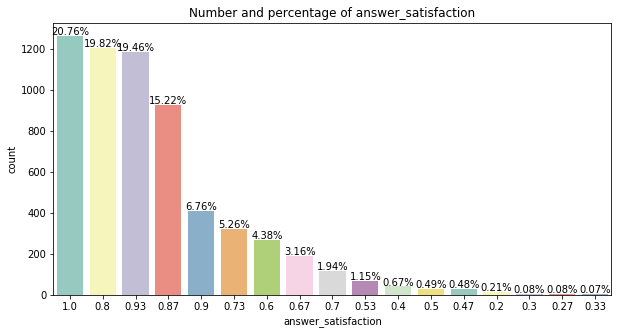

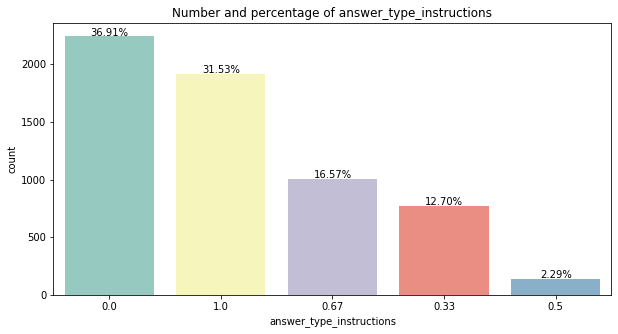

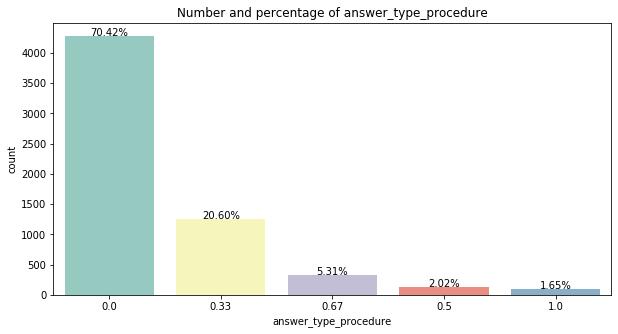

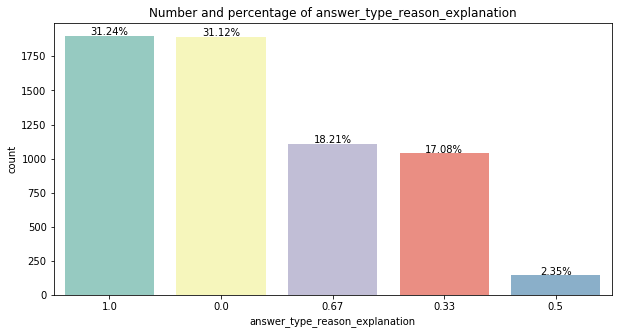

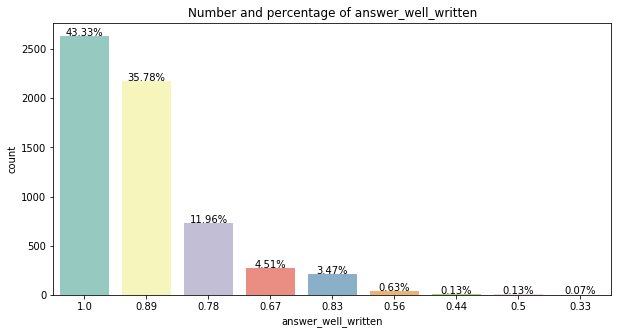

In [70]:
for col in target_columns:
    plot_count(col, col)

## Word Cloud

**wordcloud of frequent used words in the question_body**

In [72]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(20,20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

**prevalent words in the train set**\
(we will use a 6079 question_body sample and show top 100 words)

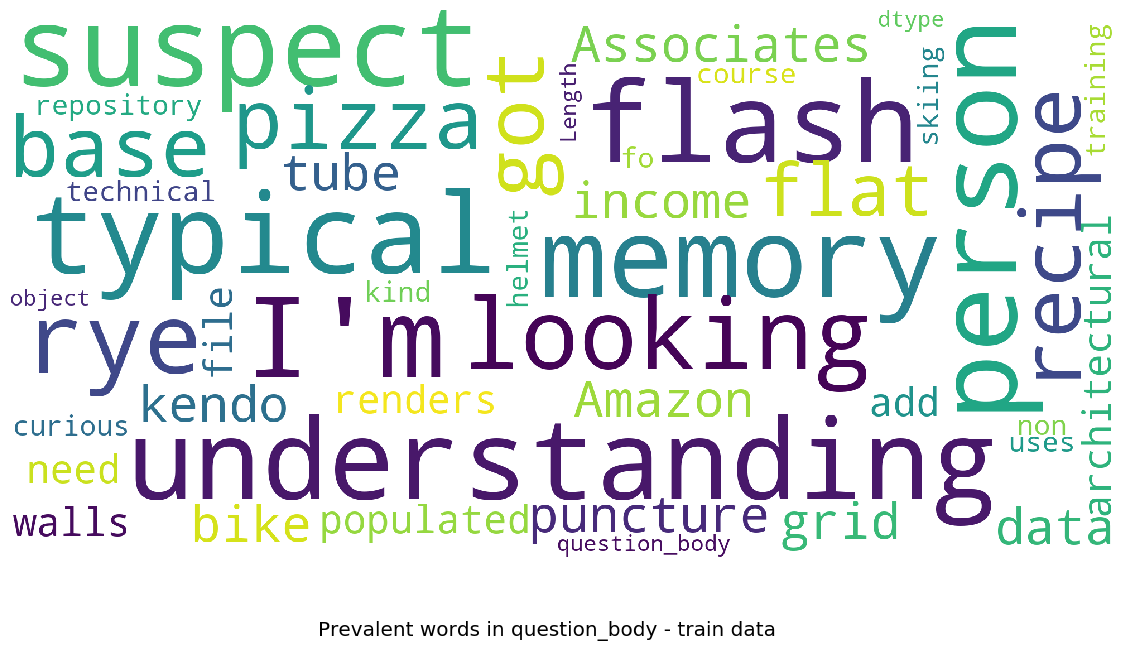

In [81]:
show_wordcloud(train['question_body'].sample(6079), title = 'Prevalent words in question_body - train data')

**frequent used words in question_body for which question_well_written score above 0.6**

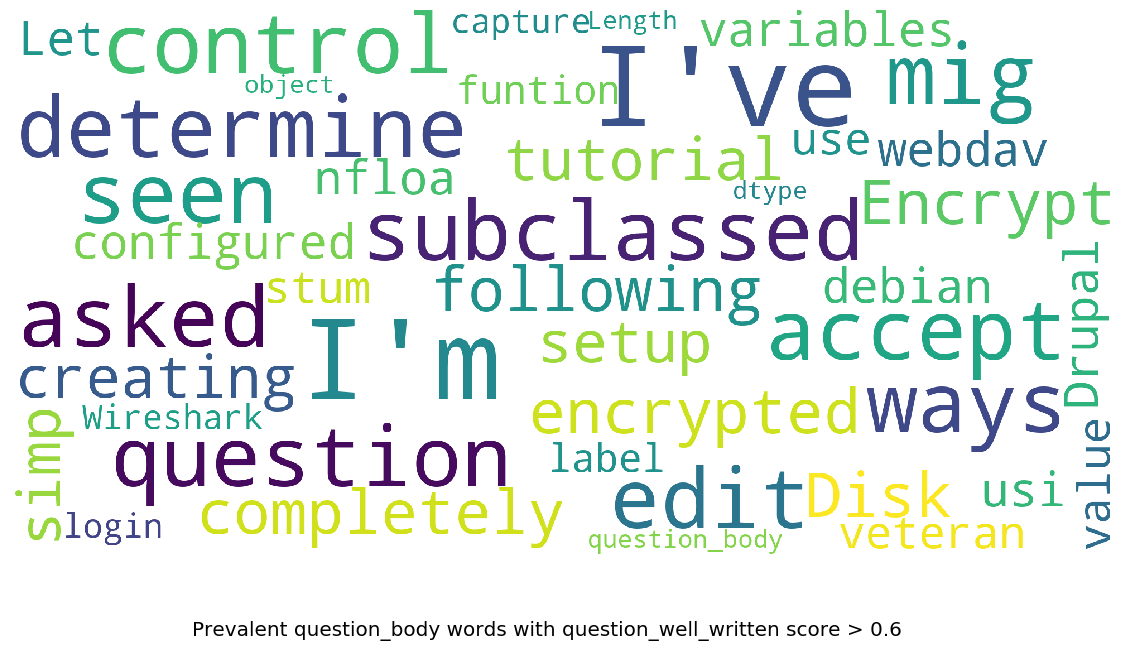

In [83]:
show_wordcloud(train.loc[train['question_well_written'] > 0.6]['question_body'].sample(3000), 
               title = 'Prevalent question_body words with question_well_written score > 0.6')

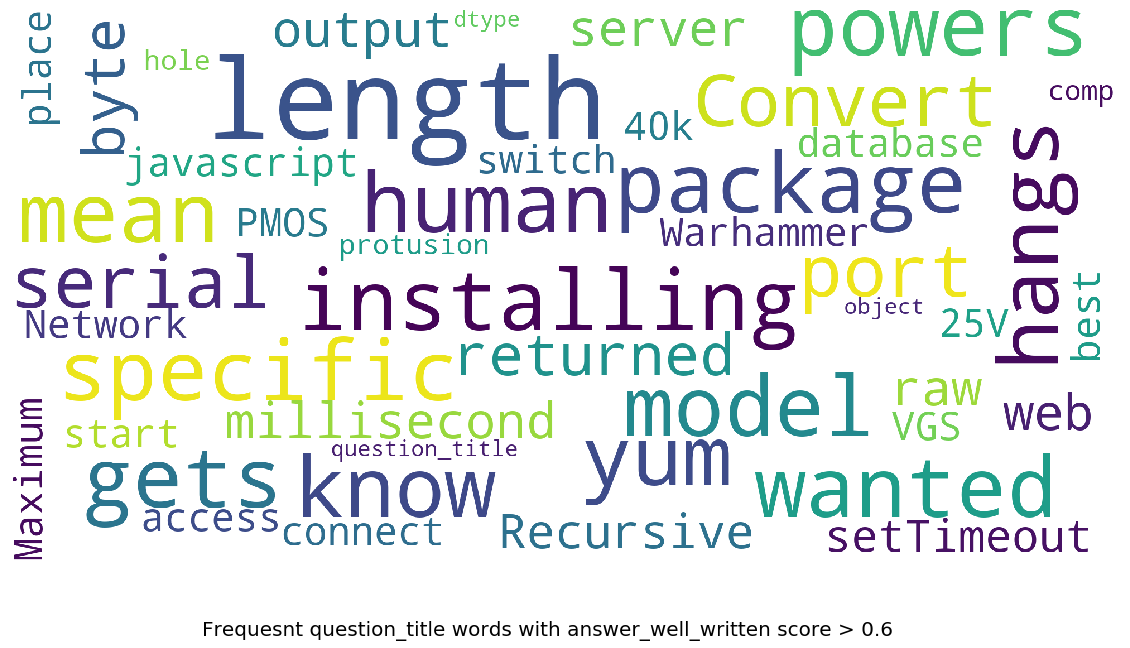

In [84]:
show_wordcloud(train.loc[train['answer_well_written'] > 0.6]['question_title'].sample(3000), 
               title = 'Frequesnt question_title words with answer_well_written score > 0.6')

# Modeling

In [85]:
import collections
import re
import unicodedata
import six
import tensorflow as tf